In [15]:
# A lot of the boilerplate code is taken from: https://keras.io/examples/nlp/text_classification_with_transformer/

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer, Embedding, Input, GlobalAveragePooling1D, Dense
import pandas as pd
from sklearn.model_selection import train_test_split

In [16]:
# Implementing the Transformer block as a layer
class TransformerLayer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Implementing the embedding layer  
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [17]:
# Preparing the data
vocab_size = 20000
maxlen = 200

# Load the data
df = pd.read_csv('spam_email.csv')
df.head()

# Split the data into train, validation and test
x_train, x_test, y_train, y_test = train_test_split(df['Text'], df['CB_Label'], test_size=0.2, random_state=42)

# Tokenize the data
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Pad the data
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [18]:
# Create the model
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerLayer(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [19]:
# Train the model
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
250/250 [==============================] - 26s 88ms/step - loss: 0.2599 - accuracy: 0.8808 - val_loss: 0.0487 - val_accuracy: 0.9830
Epoch 2/10
250/250 [==============================] - 23s 92ms/step - loss: 0.0441 - accuracy: 0.9869 - val_loss: 0.0412 - val_accuracy: 0.9815
Epoch 3/10
250/250 [==============================] - 20s 80ms/step - loss: 0.0133 - accuracy: 0.9962 - val_loss: 0.0501 - val_accuracy: 0.9895
Epoch 4/10
250/250 [==============================] - 20s 79ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0381 - val_accuracy: 0.9900
Epoch 5/10
250/250 [==============================] - 20s 81ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0613 - val_accuracy: 0.9865
Epoch 6/10
250/250 [==============================] - 21s 84ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0503 - val_accuracy: 0.9895
Epoch 7/10
250/250 [==============================] - 21s 86ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0599 - val_accuracy:

In [20]:
# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.06608748435974121
Test accuracy: 0.9879999756813049


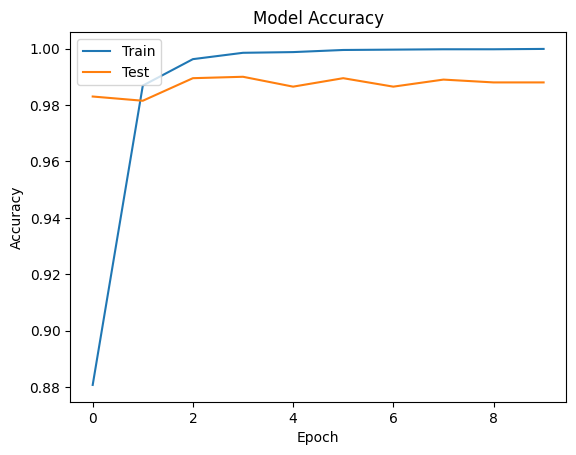

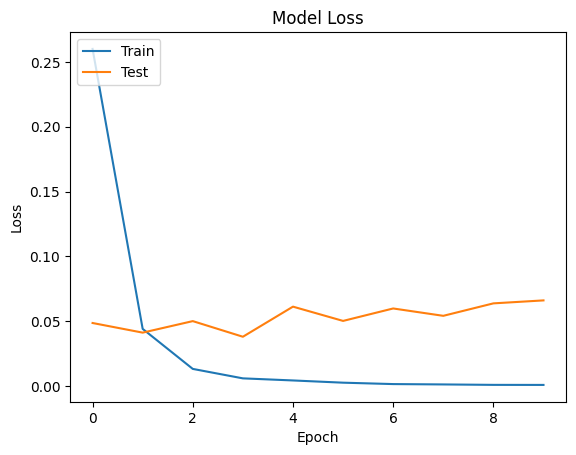

In [21]:
# Plot the accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()